In [1]:
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import pickle
import cv2
import glob
import time

%matplotlib inline

In [2]:
car_images = glob.glob('vehicles/**/*.png')
noncar_images = glob.glob('non-vehicles/**/*.png')
car_images[0]

'vehicles/GTI_Right/image0707.png'

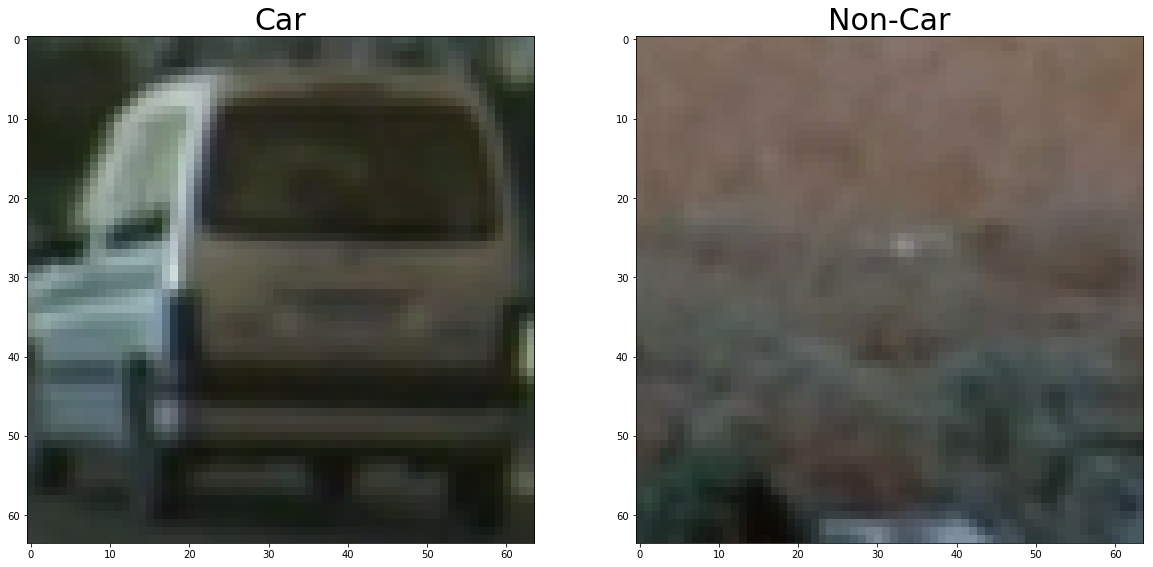

In [3]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(cv2.imread(car_images[200]))
ax1.set_title('Car', fontsize=30)
ax2.imshow(cv2.imread(noncar_images[900]))
ax2.set_title('Non-Car', fontsize=30)
plt.savefig('output_images/camera_undist.jpg')
plt.savefig('car_notcar.jpg')

In [457]:
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    
    

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


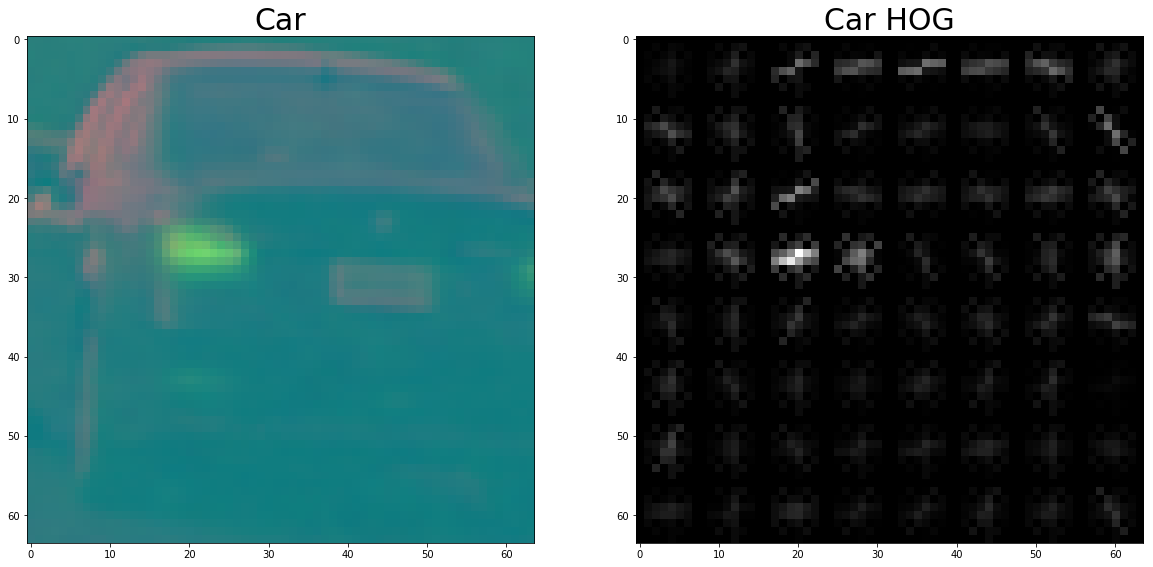

In [759]:
car_image = mpimg.imread(car_images[0])
car_image = cv2.cvtColor(car_image, cv2.COLOR_RGB2YCrCb)

_, car_hog = get_hog_features(car_image[:,:,2],9, 8, 2, vis=True, feature_vec=True)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(car_image)
ax1.set_title('Car', fontsize=30)
ax2.imshow(car_hog,cmap = 'gray')
ax2.set_title('Car HOG', fontsize=30)
plt.savefig('Hog_Features.jpg')

In [684]:
# Feature extraction parameters
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 15
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"


spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [380, 700] # Min and max in y to search in slide_window()


t = time.time()
car_features = extract_features(car_images, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(noncar_images, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))


61.65 Seconds to extract HOG features...
Using: 15 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 11988


In [685]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a si]ngle sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

5.57 Seconds to train SVC...
Test Accuracy of SVC =  0.9938
My SVC predicts:  [ 0.  0.  0.  0.  1.  0.  0.  0.  1.  0.]
For these 10 labels:  [ 0.  0.  0.  0.  1.  0.  0.  0.  1.  0.]
0.00146 Seconds to predict 10 labels with SVC


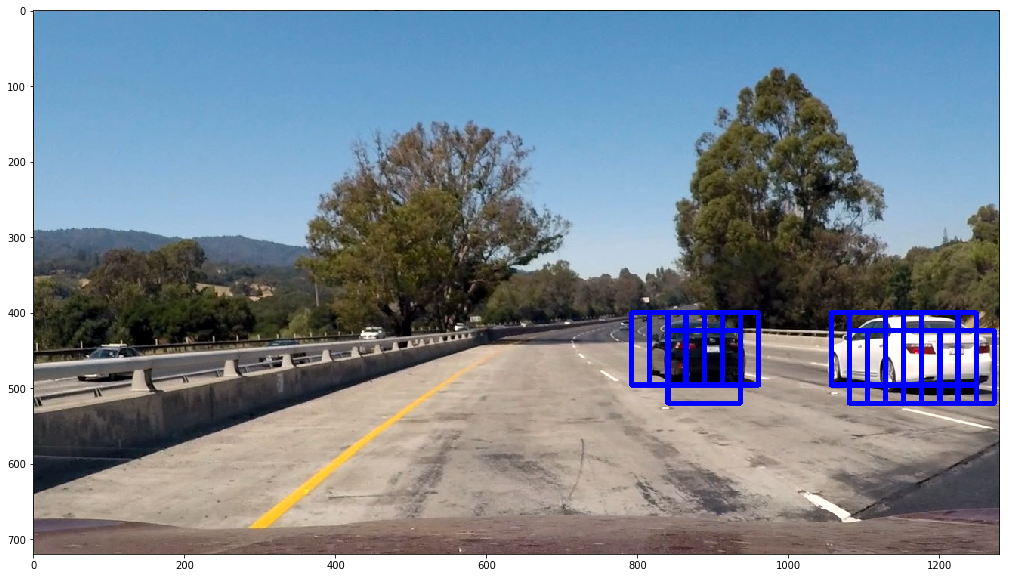

In [769]:


img = mpimg.imread('test_images/test1.jpg')
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    boxes = []
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
                
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    return draw_img, boxes
    
ystart = 400
ystop = 550
scale = 1.5

out_img, boxes = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
fig = plt.figure(figsize=(20,10))

plt.imshow(out_img)
##plt.title("", fontsize = 30)

plt.savefig('test1Box.jpg')

Number of boxes:  20


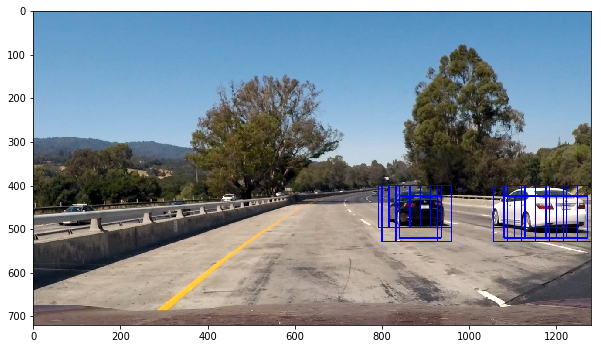

In [687]:
test_img = mpimg.imread('./test_images/test1.jpg')

rects = []

ystart = 400
ystop = 550
scale = 1.5
_, box =find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
rects.append(box)
ystart = 400
ystop = 650
scale = 2
_, box = find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
rects.append(box)

rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('Number of boxes: ', len(rectangles))

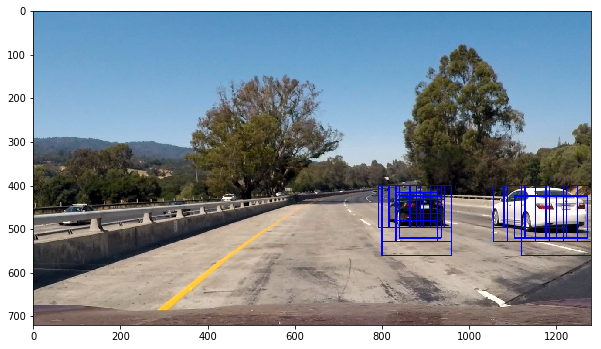

In [688]:
scales = [(1.0,400,500),(2.0,400,550),(2.5,400,650)]
#scales = [(1.0,380,550),(1.5,400,550),(1.4,380,550),(1.8,380,600),(2.1,400,650),(2.6,420,680),(3.0,420,719)]
scales = [(1.0,400,550),(2.0,400,650)]
box_list = []
scales = [(1.0,400,550),(1.5,400,600),(2.0,400,650),(2.5,400,680)]
for scaler in scales:
    _, boxes = find_cars(test_img, scaler[1], scaler[2], scaler[0], svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    box_list += boxes
test_img_rects = draw_boxes(test_img, box_list, thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)

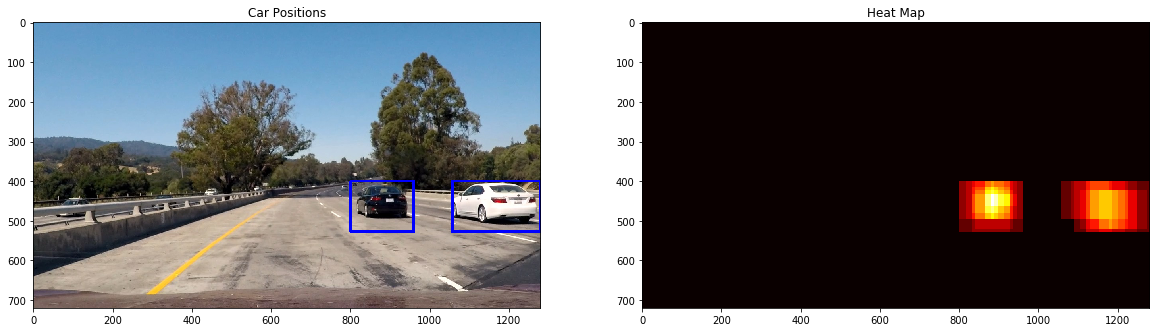

In [766]:

# Read in image similar to one shown above 
image = mpimg.imread('test_images/test1.jpg')
heat = np.zeros_like(image[:,:,0]).astype(np.float)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure()
plt.figure(figsize=(20,10))
plt.subplot(121)

plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')

fig.tight_layout()
plt.savefig('heatmap.jpg')

2 cars found
<class 'tuple'>


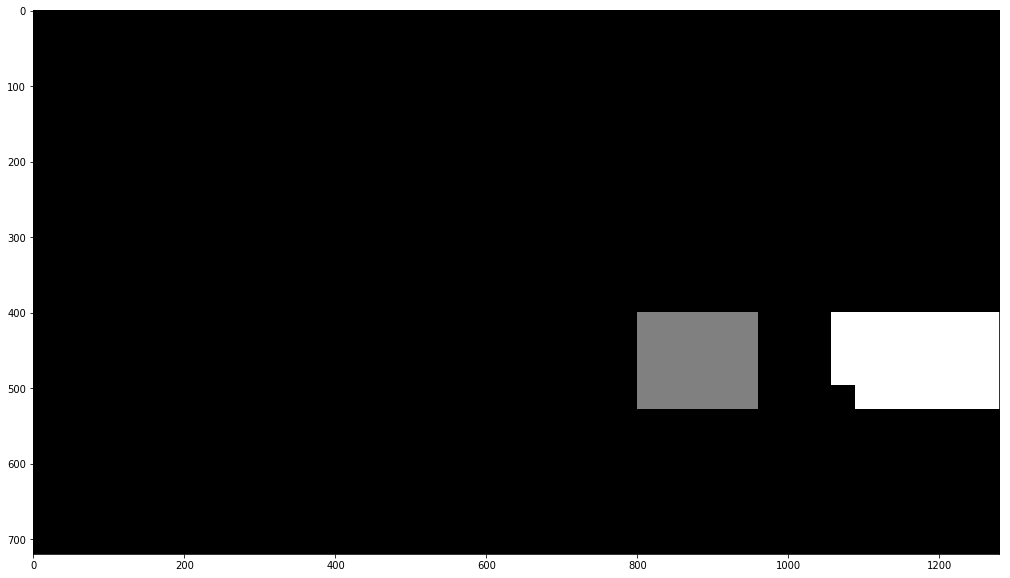

In [768]:
labels = label(heatmap)
plt.figure(figsize=(20,10))
plt.imshow(labels[0], cmap='gray')
print(labels[1], 'cars found')
plt.savefig('boxFromHeatmap.jpg')
print(type(labels))

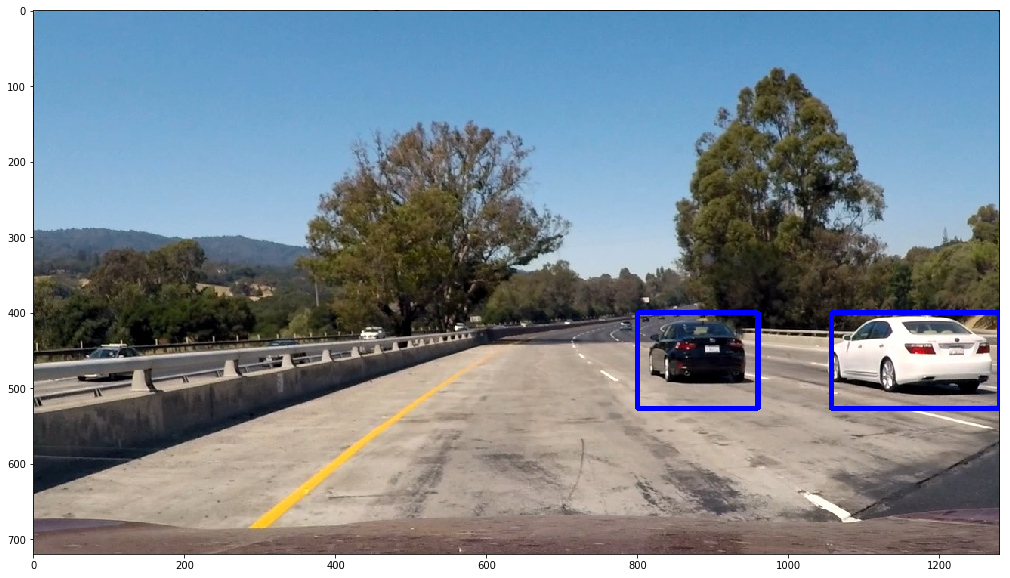

In [767]:


# Draw bounding boxes on a copy of the image
draw_img = draw_labeled_bboxes(np.copy(test_img), labels)
# Display the image
plt.figure(figsize=(20,10))
plt.imshow(draw_img)
plt.savefig('boxDrawn.jpg')

In [750]:
# scales = [(1.0,380,550),(1.25,400,550),(1.5,380,550),(1.8,380,600),(2.1,400,650),(2.6,420,680),(3.0,420,719)]
scales = [(1.0,380,550),(1.5,400,550),(1.4,380,550),(1.8,380,600),(2.1,400,650),(2.6,420,680),(3.0,420,719)]
# scales = [(1.0,400,550),(1.5,400,600),(2.0,400,650),(2.5,400,680)]
#scales = [(1.0,380,550),(2.0,380,650),(3.0,380,719)]
#scales = [(.75,380,550),(1.0,380,550),(2.0,380,650)]

from collections import deque
heat_list = deque(maxlen = 6)
def process(img):
    
    box_list = []
    for scaler in scales:
        _, boxes = find_cars(img, scaler[1], scaler[2], scaler[0], svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        box_list += boxes
    
    heat = np.zeros_like(out_img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat, box_list)

    # Apply threshold to help remove false positives
   
    heat = apply_threshold(heat, 1)

    # Visualize the heatmap when displaying    
    current_heatmap = np.clip(heat, 0, 255)
    heat_list.append(current_heatmap)
    
    heatmap = np.zeros_like(current_heatmap).astype(np.float)
    for heat in heat_list:
        heatmap = heatmap + heat
        
    heatmap = apply_threshold(heat, 2)
    heatmap = np.clip(heatmap, 0, 255)
    
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    if len(heat_list)< 5:
        return img
    draw_img = draw_labeled_bboxes(img, labels)
    return draw_img


In [746]:
test_out_file = 'test.mp4'
heat_list = deque(maxlen = 8)
clip_test = VideoFileClip('project_video.mp4').subclip(24,26)
clip_test_out = clip_test.fl_image(process)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video test.mp4
[MoviePy] Writing video test.mp4


 98%|█████████▊| 50/51 [01:01<00:01,  1.22s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test.mp4 

CPU times: user 1min 1s, sys: 236 ms, total: 1min 1s
Wall time: 1min 2s


In [747]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>heat_list.insert(0,heat)
""".format(test_out_file))

In [754]:
proj_out_file = 'project_video_out.mp4'
heat_list = deque(maxlen = 8)
clip_proj = VideoFileClip('project_video.mp4')#.subclip(39,42) 

clip_proj_out = clip_proj.fl_image(process)
%time clip_proj_out.write_videofile(proj_out_file, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4



 12%|█▏        | 152/1261 [03:03<22:15,  1.20s/it]


 24%|██▍       | 303/1261 [06:06<19:29,  1.22s/it]


 36%|███▌      | 454/1261 [09:09<16:13,  1.21s/it]


 48%|████▊     | 605/1261 [12:15<13:35,  1.24s/it]


 60%|█████▉    | 756/1261 [15:22<10:34,  1.26s/it]


 72%|███████▏  | 907/1261 [18:30<07:28,  1.27s/it]


 84%|████████▍ | 1057/1261 [21:35<04:18,  1.27s/it]


 96%|█████████▌| 1205/1261 [24:36<01:10,  1.26s/it]


100%|█████████▉| 1260/1261 [25:44<00:01,  1.24s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 25min 54s, sys: 3.44 s, total: 25min 58s
Wall time: 25min 45s


In [755]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(proj_out_file))